In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install kaggle

In [3]:
import json

kaggle_credentials = json.load(open("kaggle.json"))

In [4]:
import os
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

In [5]:
!kaggle datasets download -d arjuntejaswi/plant-village

Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village
License(s): unknown
plant-village.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!ls

kaggle.json  models.pth  PlantVillage  plant-village.zip  sample_data


In [7]:
from zipfile import ZipFile

with ZipFile("plant-village.zip", 'r') as zip_ref:
    zip_ref.extractall()


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
from PIL import Image



In [9]:

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class FasterCNN(nn.Module):
    def __init__(self, num_classes):
        super(FasterCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            DepthwiseSeparableConv(3, 48),  
            nn.ReLU(),
            nn.BatchNorm2d(48),
            DepthwiseSeparableConv(48, 96), 
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(2, 2),
            DepthwiseSeparableConv(96, 192), 
            nn.ReLU(),
            nn.BatchNorm2d(192),
            nn.MaxPool2d(2, 2),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.4),  
            nn.Linear(192, num_classes)  
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [10]:
# ✅ Step 1: Define Transformations
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.RandomResizedCrop(128, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [11]:
# ✅ Step 2: Load Dataset & Split into Train and Test
full_dataset = datasets.ImageFolder(root="PlantVillage", transform=train_transform)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_data, test_data = random_split(full_dataset, [train_size, test_size])

In [12]:
# Assign correct transformations
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform


train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=4)


num_classes = len(full_dataset.classes)  # Get number of classes
print(f"Dataset split: {train_size} train, {test_size} test.")
print(f"Number of Classes: {num_classes}")

Dataset split: 16510 train, 4128 test.
Number of Classes: 15


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [13]:
# ✅ Step 3: Define CNN Model (More Layers)
import torch.nn.functional as F
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    index = torch.randperm(x.size(0)).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [14]:
# Define device (Use GPU if available, else fallback to CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now initialize the model
model = FasterCNN(num_classes=num_classes).to(device)


In [18]:
# ✅ Step 4: Initialize Model, Loss & Optimizer
model = FasterCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.04)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [19]:
# ✅ Step 5: Enable Mixed Precision (FP16 Training)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-19-bd0b9110d002>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [20]:
# Initialize GradScaler for mixed precision training
scaler = GradScaler()

num_epochs = 10
best_accuracy = 0.0

train_losses = []   # Store training loss for each epoch
val_accuracies = [] # Store validation accuracy for each epoch

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()  # Scale loss and backpropagate
        scaler.step(optimizer)         # Update weights
        scaler.update()                # Update the scale for next iteration

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Store loss for this epoch

    # Validation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "models.pth")
        print("✔ Model Saved!")

<ipython-input-20-6aeadd33b9f9>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-20-6aeadd33b9f9>:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/10], Loss: 1.6734, Accuracy: 53.51%
✔ Model Saved!
Epoch [2/10], Loss: 1.3672, Accuracy: 67.64%
✔ Model Saved!
Epoch [3/10], Loss: 1.2318, Accuracy: 65.87%
Epoch [4/10], Loss: 1.0895, Accuracy: 70.71%
✔ Model Saved!
Epoch [5/10], Loss: 1.0250, Accuracy: 83.48%
✔ Model Saved!
Epoch [6/10], Loss: 1.0223, Accuracy: 82.78%
Epoch [7/10], Loss: 0.9210, Accuracy: 70.93%
Epoch [8/10], Loss: 0.8847, Accuracy: 79.53%
Epoch [9/10], Loss: 0.8542, Accuracy: 87.35%
✔ Model Saved!
Epoch [10/10], Loss: 0.8186, Accuracy: 81.06%


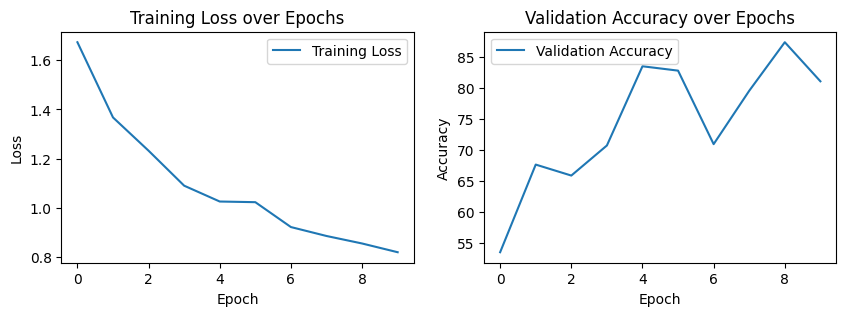

In [23]:
plt.figure(figsize=(10, 3))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.show()

In [ ]:
import torch
torch.cuda.empty_cache()


In [24]:
def single_prediction(image_path, model, class_labels, device):
    """
    Predicts the disease class of a plant leaf image using a trained CNN model.

    Parameters:
    - image_path (str): Path to the input image.
    - model (torch.nn.Module): Trained CNN model.
    - class_labels (list): List of class names.
    - device (torch.device): Device where the model is running (CPU/GPU).

    Returns:
    - str: Predicted class name.
    """
    # Load the image
    try:
        image = Image.open(image_path).convert("RGB")  # Ensure it's an RGB image
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None

    # Define the transformation (should match training preprocessing)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension & move to correct device

    # Ensure model is in evaluation mode
    model.eval()

    # Perform prediction
    with torch.no_grad():
        output = model(image)
        predicted_class_idx = torch.argmax(output, dim=1).item()

    # Get class name from label list
    predicted_class = class_labels[predicted_class_idx]

    return predicted_class


In [25]:
print(single_prediction("/content/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG", model, full_dataset.classes, device))


Pepper__bell___Bacterial_spot


In [27]:
print(single_prediction("/content/PlantVillage/Tomato_Bacterial_spot/00639d29-2d1a-4fcf-9bd3-a2b3109c74c4___UF.GRC_BS_Lab Leaf 1054.JPG", model, full_dataset.classes, device))


Tomato_Bacterial_spot
